In [11]:
import math
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.losses import mean_squared_error, mean_absolute_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import SimpleRNN,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('stock_data.csv')
train_data = data[0:-50]['open'].values.reshape(-1, 1)
test_data = data[-50:]['open'].values.reshape(-1, 1)

# 归一化
sc = MinMaxScaler()
train_set = sc.fit_transform(train_data)
test_set = sc.transform(test_data)

x_train = []
y_train = []
x_test = []
y_test = []

for i in range(15, len(train_set)):
    x_train.append(train_set[i - 15:i])
    y_train.append(train_set[i, 0])

np.random.seed(8)
np.random.shuffle(x_train)
np.random.seed(8)
np.random.shuffle(y_train)

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,newshape=(x_train.shape[0],15,1))

for i in range(15, len(test_set)):
    x_test.append(test_set[i - 15:i])
    y_test.append(test_set[i, 0])
# RNN 要求 [送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test,y_test = np.array(x_test),np.array(y_test)
x_test = np.reshape(x_test,newshape=(x_test.shape[0],15,1))

In [13]:
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/rnn_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

-------------load the model-----------------
Epoch 1/50
9/9 [==============================] - 2s 95ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 2/50
9/9 [==============================] - 1s 71ms/step - loss: 0.0020 - val_loss: 0.0012

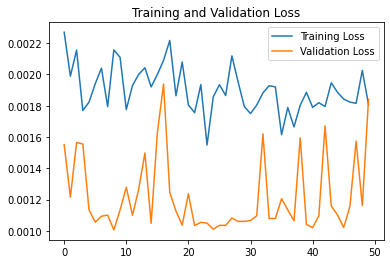

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

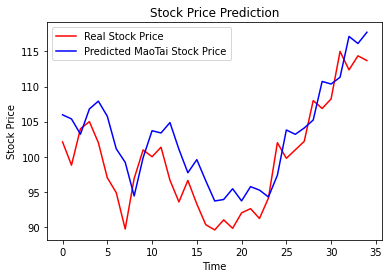

In [15]:
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(y_test.reshape(-1,1))
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [19]:
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price.flatten(), real_stock_price.flatten())
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mse)
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price.flatten(), real_stock_price.flatten())
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 21.376601
均方根误差: 4.623484
平均绝对误差: 3.990852
